# [作業目標]
- 使用 Day 12 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 12 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [16]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # 另一個繪圖-樣式套件


# 忽略警告訊息
import warnings
warnings.filterwarnings('ignore')

# 設定 data_path
dir_data = './data/'

### 之前做過的處理

In [2]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [4]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 123)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [5]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## 練習時間
參考 Day 12 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [6]:
# 將年紀分群 0~100,分10群
app_train["YEARS_BIRTH"] = app_train['DAYS_BIRTH']/365
bin_cut = np.linspace(0, 100, num=11)
app_train["ages_group"] = pd.cut(app_train['YEARS_BIRTH'], bins=bin_cut)
print(app_train['ages_group'].value_counts())
#得到年齡分布在30~70歲之間


(30.0, 40.0]     82308
(40.0, 50.0]     76541
(50.0, 60.0]     68062
(20.0, 30.0]     45021
(60.0, 70.0]     35579
(90.0, 100.0]        0
(80.0, 90.0]         0
(70.0, 80.0]         0
(10.0, 20.0]         0
(0.0, 10.0]          0
Name: ages_group, dtype: int64


In [8]:
# 將就業年資分群, 0~50年 ,每 10為一單位
app_train["YEAR_EMPLOYED"] = app_train['DAYS_EMPLOYED']/(-365)
bin_cut = [0,10,20,30,40,50]
app_train["equal_width_year_employed"] = pd.cut(app_train['YEAR_EMPLOYED'], bins= bin_cut)
app_train['equal_width_year_employed'].value_counts().sort_index()

(0, 10]     201181
(10, 20]     38398
(20, 30]      9551
(30, 40]      2771
(40, 50]       234
Name: equal_width_year_employed, dtype: int64

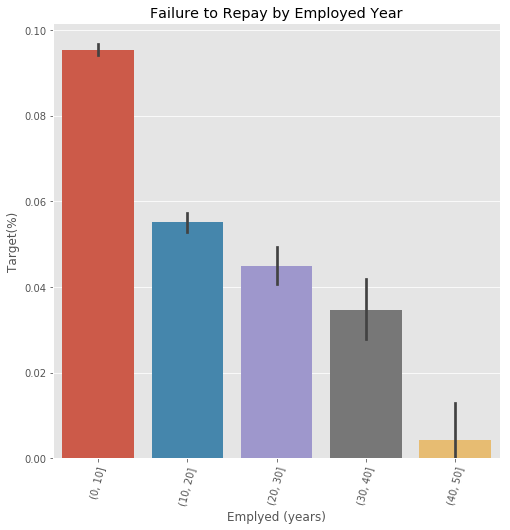

In [17]:
# 觀察年資長短與 Target關係
plt.figure(figsize = (8, 8))
# 以 Year_Employed為 x, Target為 y
px = app_train['equal_width_year_employed']
py = app_train['TARGET']
sns.barplot(px, py)

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Emplyed (years)'); plt.ylabel('Target(%)')
plt.title('Failure to Repay by Employed Year');

In [21]:
# 將年紀細分為,每5歲為區間
age_data = app_train[['TARGET', 'DAYS_BIRTH']] # subset
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365 # day-age to year-age

bin_cut =  np.linspace(20, 70, num=11) # np.linspace等差數列
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = bin_cut) 

# 顯示不同組的數量
print(age_data['YEARS_BINNED'].value_counts())
age_data.head()

(35.0, 40.0]    42868
(40.0, 45.0]    41406
(30.0, 35.0]    39440
(45.0, 50.0]    35135
(50.0, 55.0]    34942
(55.0, 60.0]    33120
(25.0, 30.0]    32862
(60.0, 65.0]    27476
(20.0, 25.0]    12159
(65.0, 70.0]     8103
Name: YEARS_BINNED, dtype: int64


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"


Text(0.5, 1.0, 'INCOME group v.s TARGET')

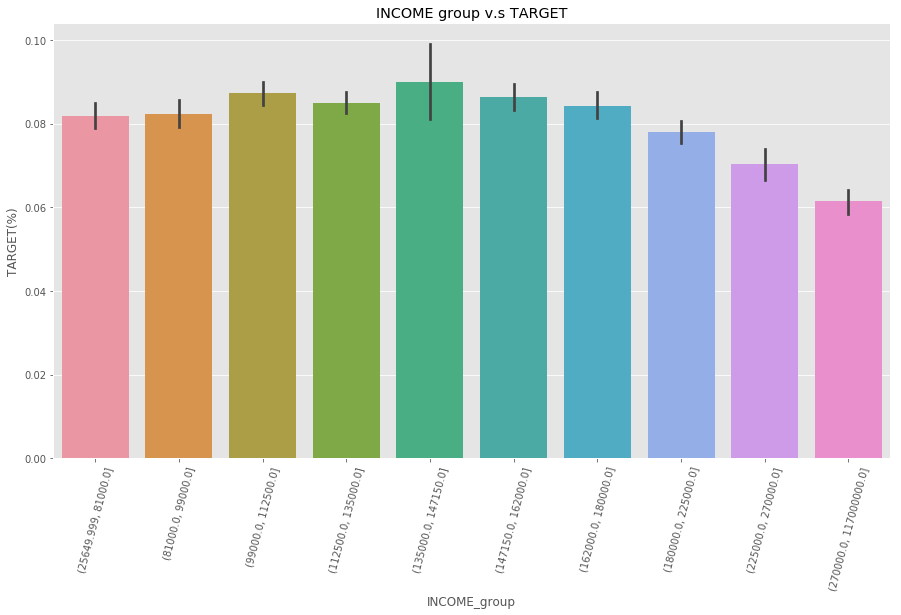

In [23]:
# 觀察年收入與 Target關係
app_train["INCOME_group"] = pd.qcut(app_train['AMT_INCOME_TOTAL'], 10)

plt.figure(figsize= (15,8))
px = app_train['INCOME_group']
py = app_train['TARGET']

sns.barplot(px, py)

# plot.label
plt.xticks(rotation = 75); plt.xlabel('INCOME_group'); plt.ylabel('TARGET(%)')
plt.title('INCOME group v.s TARGET')